In [2]:
import os
import json
import re
import hashlib
import numpy as np
from collections import defaultdict
from pathlib import Path
from threading import Lock
from typing import TypedDict, Annotated, Sequence, Dict, Optional, List, Literal, Type
from uuid import uuid4
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [4]:
api_key = os.environ.get("NVIDIA_API_KEY")
if not api_key:
    raise RuntimeError("🚨 NVIDIA_API_KEY not found in environment!")

In [5]:
# Constants
FAISS_PATH = "data/faiss_store/v64_600-150"
CHUNKS_PATH = "data/all_chunks.json"

In [6]:
# Validate files
if not Path(FAISS_PATH).exists():
    raise FileNotFoundError(f"FAISS index not found at {FAISS_PATH}")
if not Path(CHUNKS_PATH).exists():
    raise FileNotFoundError(f"Chunks file not found at {CHUNKS_PATH}")

In [7]:
KRISHNA_BIO = """Krishna Vamsi Dhulipalla completed masters in Computer Science at Virginia Tech, awarded degree in december 2024, with over 3 years of experience across data engineering, machine learning research, and real-time analytics. He specializes in building scalable data systems and intelligent LLM-powered applications, with strong expertise in Python, PyTorch, Hugging Face Transformers, and end-to-end ML pipelines.
He has led projects involving retrieval-augmented generation (RAG), feature selection for genomic classification, fine-tuning domain-specific LLMs (e.g., DNABERT, HyenaDNA), and real-time forecasting systems using Kafka, Spark, and Airflow. His cloud proficiency spans AWS (S3, SageMaker, ECS, CloudWatch), GCP (BigQuery, Cloud Composer), and DevOps tools like Docker, Kubernetes, and MLflow.
Krishna’s research has focused on genomic sequence modeling, transformer optimization, MLOps automation, and cross-domain generalization. He has published work in bioinformatics and machine learning applications for circadian transcription prediction and transcription factor binding.
He holds certifications in NVIDIA’s RAG Agents with LLMs, Google Cloud Data Engineering, and AWS ML Specialization. Krishna is passionate about scalable LLM infrastructure, data-centric AI, and domain-adaptive ML solutions — combining deep technical expertise with real-world engineering impact.
\n\n
Beside carrer, Krishna loves hiking, cricket, and exploring new technologies. He is big fan of Marvel Movies and Space exploration.
"""

In [8]:
# Load resources
def load_chunks(path=CHUNKS_PATH) -> List[Dict]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_faiss(path=FAISS_PATH, model_name="sentence-transformers/all-MiniLM-L6-v2") -> FAISS:
    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    return FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True)

In [9]:
vectorstore = load_faiss()
all_chunks = load_chunks()
all_texts = [chunk["text"] for chunk in all_chunks]
metadatas = [chunk["metadata"] for chunk in all_chunks]
bm25_retriever = BM25Retriever.from_texts(texts=all_texts, metadatas=metadatas)

c:\Users\vamsi\OneDrive\Desktop\LangGraph\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
K_PER_QUERY    = 8         # how many from each retriever
TOP_K          = 8         # final results to return
RRF_K          = 60        # reciprocal-rank-fusion constant
RERANK_TOP_N   = 50        # rerank this many fused hits
MMR_LAMBDA     = 0.7       # 0..1 (higher favors query relevance; lower favors diversity)
CE_MODEL       = "cross-encoder/ms-marco-MiniLM-L-6-v2"
ALPHA = 0.7

In [11]:
from sentence_transformers import CrossEncoder
_cross_encoder = CrossEncoder(CE_MODEL)

c:\Users\vamsi\OneDrive\Desktop\LangGraph\env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vamsi\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falli

In [12]:
embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2",
        model_kwargs={"device": "cpu"},
        encode_kwargs={"normalize_embeddings": True},
    )

In [13]:
def _cosine_sim_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    # A: mxd, B: nxd, both should be L2-normalized
    return A @ B.T

def _l2_normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v, axis=1, keepdims=True) + 1e-12
    return v / n

def _mmr_select(query_vec: np.ndarray, cand_vecs: np.ndarray, k: int, mmr_lambda: float):
    # returns list of selected indices using MMR
    selected = []
    remaining = list(range(cand_vecs.shape[0]))

    # precompute similarities
    q_sim = (cand_vecs @ query_vec.reshape(-1, 1)).ravel()  # cosine since normalized
    doc_sims = _cosine_sim_matrix(cand_vecs, cand_vecs)

    # pick first by highest query similarity
    first = int(np.argmax(q_sim))
    selected.append(first)
    remaining.remove(first)

    while remaining and len(selected) < k:
        # for each remaining, compute MMR score = λ * Sim(q, d) - (1-λ) * max Sim(d, s in selected)
        sub = np.array(remaining)
        sim_to_selected = doc_sims[np.ix_(sub, selected)].max(axis=1)
        mmr_scores = mmr_lambda * q_sim[sub] - (1.0 - mmr_lambda) * sim_to_selected
        nxt = int(sub[np.argmax(mmr_scores)])
        selected.append(nxt)
        remaining.remove(nxt)

    return selected

In [ ]:
@tool("retriever")
def retriever(query: str) -> list[str]:
    """Retrieve relevant chunks from the profile using FAISS + BM25, fused with RRF."""
    # ensure both retrievers return K_PER_QUERY
    # For BM25Retriever in LangChain this is usually `.k`
    try:
        bm25_retriever.k = K_PER_QUERY
    except Exception:
        pass

    vec_hits = vectorstore.similarity_search_with_score(query, k=K_PER_QUERY)  # [(Document, score)]
    bm_hits  = bm25_retriever.invoke(query)                                    # [Document]

    # --- fuse via RRF (rank-only) ---
    fused = defaultdict(lambda: {
        "rrf": 0.0,
        "vec_rank": None, "bm_rank": None,
        "content": None, "metadata": None,
    })

    for rank, (doc, _score) in enumerate(vec_hits):
        key = hashlib.md5(doc.page_content.encode("utf-8")).hexdigest()
        fused[key]["rrf"] += 1.0 / (rank + 1 + RRF_K)
        fused[key]["vec_rank"] = rank
        fused[key]["content"] = doc.page_content    # keep FULL text
        fused[key]["metadata"] = getattr(doc, "metadata", {}) or {}

    for rank, doc in enumerate(bm_hits):
        key = hashlib.md5(doc.page_content.encode("utf-8")).hexdigest()
        fused[key]["rrf"] += 1.0 / (rank + 1 + RRF_K)
        fused[key]["bm_rank"] = rank
        fused[key]["content"] = doc.page_content    # keep FULL text
        fused[key]["metadata"] = getattr(doc, "metadata", {}) or {}

    items = list(fused.values())
    items.sort(key=lambda x: x["rrf"], reverse=True)

    # --- cross-encoder rerank on top-N (keeps exact text; just reorders) ---
    topN = items[:RERANK_TOP_N] if RERANK_TOP_N > 0 else items
    try:
        pairs = [(query, it["content"] or "") for it in topN]
        ce_scores = _cross_encoder.predict(pairs)  # higher is better
        for it, s in zip(topN, ce_scores):
            it["rerank"] = float(s)
        topN.sort(key=lambda x: x.get("rerank", 0.0), reverse=True)
    except Exception as e:
        # if CE fails, fall back to RRF order
        for it in topN:
            it["rerank"] = it["rrf"]

    # --- MMR diversity on the reranked list (uses your HF embeddings) ---
    try:
        # embed the query + candidates; normalize to cosine space
        emb_fn = getattr(vectorstore, "embedding_function", embeddings)
        q_vec  = np.array(emb_fn.embed_query(query), dtype=np.float32).reshape(1, -1)
        d_vecs = np.array(emb_fn.embed_documents([it["content"] or "" for it in topN]), dtype=np.float32)

        q_vec  = _l2_normalize(q_vec)[0]     # (d,)
        d_vecs = _l2_normalize(d_vecs)       # (N, d)

        sel_idx = _mmr_select(q_vec, d_vecs, k=TOP_K, mmr_lambda=MMR_LAMBDA)
        final_items = [topN[i] for i in sel_idx]
    except Exception as e:
        # fallback: take first TOP_K after rerank
        final_items = topN[:TOP_K]

    # --- return verbatim content, with soft dedupe by (source, first 300 normalized chars) ---
    results = []
    seen = set()
    for it in final_items:
        content = it["content"] or ""
        meta = it["metadata"] or {}
        source = meta.get("source", "")

        # fingerprint for dedupe (does NOT modify returned text)
        clean = re.sub(r"\W+", "", content.lower())[:300]
        fp = (source, clean)
        if fp in seen:
            continue
        seen.add(fp)
        results.append(content)

        if len(results) >= TOP_K:
            break
        
    # optional: quick debug
    from pprint import pprint
    pprint([{
        "content": i["content"],
      "src": (i["metadata"] or {}).get("source", ""),
      "rrf": round(i["rrf"], 6),
      "vec_rank": i["vec_rank"],
      "bm_rank": i["bm_rank"],
    } for i in final_items], width=120)

    return results

In [15]:
tools = [ retriever ]

In [16]:
model = ChatOpenAI(
    model="gpt-4o",              
    temperature=0.3,             
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    streaming=True
).bind_tools(tools)

In [17]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [18]:
system_prompt = SystemMessage(
    content=(
        "You are Krishna's personal AI assistant. "
        "Use the retriever tool to fetch context about Krishna when the user asks about him. "
        "Cite concrete facts from retrieved chunks (no fabrication)."
    )
)

In [19]:
def model_call(state: AgentState) -> AgentState:
    """Call the model with the current state messages."""
    msgs = [system_prompt, *state["messages"]]
    ai_msg = model.invoke(msgs)                 # returns an AIMessage with .tool_calls if any
    return {"messages": [ai_msg]}

In [20]:
def should_continue(state: AgentState) -> Literal["continue", "end"]:
    """Determine if the agent should continue."""
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "continue"
    return "end"

In [21]:
graph = StateGraph(AgentState)

graph.add_node('agent', model_call)
tools_node = ToolNode(tools=tools)
graph.add_node('tools', tools_node)

graph.add_edge(START, 'agent')
graph.add_conditional_edges('agent', should_continue, {
    "continue": 'tools',
    "end": END})
graph.add_edge('tools', 'agent')

checkpointer = MemorySaver()  # dev-only; for prod use SQLite/Postgres
app = graph.compile(checkpointer=checkpointer)

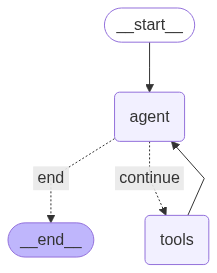

In [22]:
app

In [23]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [24]:
def run_turn(thread_id: str, user_text: str):
    config = {"configurable": {"thread_id": thread_id}}
    final_text = ""
    for s in app.stream({"messages": [("user", user_text)]}, config=config, stream_mode="values"):
        msg = s["messages"][-1]
        # stream-friendly: accumulate only the latest AI message content if present
        if getattr(msg, "content", None) and msg.type == "ai":
            final_text = msg.content
    return final_text

In [25]:
thread_id = str(uuid4())  # persist per user/session
print(run_turn(thread_id, "tell me about Krishna Vamsi Dhulipalla"))
print(run_turn(thread_id, "what are his favorite foods?"))

[{'bm_rank': None, 'rrf': 0.016393, 'src': 'xPersonal_Interests_Cleaned.md', 'vec_rank': 0},
 {'bm_rank': None, 'rrf': 0.016129, 'src': 'aprofile.md', 'vec_rank': 1},
 {'bm_rank': None, 'rrf': 0.015152, 'src': 'xPersonal_Interests_Cleaned.md', 'vec_rank': 5},
 {'bm_rank': None, 'rrf': 0.014706, 'src': 'aprofile.md', 'vec_rank': 7},
 {'bm_rank': 2, 'rrf': 0.015873, 'src': 'aprofile.md', 'vec_rank': None},
 {'bm_rank': None, 'rrf': 0.014925, 'src': 'xPersonal_Interests_Cleaned.md', 'vec_rank': 6},
 {'bm_rank': None, 'rrf': 0.015873, 'src': 'aprofile.md', 'vec_rank': 2},
 {'bm_rank': 5, 'rrf': 0.015152, 'src': 'aprofile.md', 'vec_rank': None}]
Krishna Vamsi Dhulipalla is a Computer Science graduate student at Virginia Tech, expected to complete his Master of Engineering (M.Eng) in December 2024. He has over three years of experience in data engineering, machine learning research, and real-time analytics. His professional interests are focused on LLM-driven systems, genomic computing, and 

In [ ]:
from fastapi import FastAPI, Request, Query
from pydantic import BaseModel
from sse_starlette.sse import EventSourceResponse

In [ ]:
api = FastAPI()

# Optional CORS for local dev (if your UI runs on another port)
from fastapi.middleware.cors import CORSMiddleware
api.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # tighten for prod
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

In [ ]:
async def _event_stream(thread_id: str, message: str, request: Request):
    """Common streamer for GET/POST routes."""
    config = {"configurable": {"thread_id": thread_id}}

    # You can emit the thread id up front; UI also accepts it at the end.
    yield {"event": "thread", "data": thread_id}

    try:
        async for event in app.astream_events(
            {"messages": [("user", message)]},
            config=config,
            version="v2",
        ):
            # Stream model tokens
            if event["event"] == "on_chat_model_stream":
                chunk = event["data"]["chunk"].content
                # Guard: sometimes chunk is empty or a list of parts
                if isinstance(chunk, list):
                    # join any text parts if needed
                    text = "".join(getattr(p, "text", "") or str(p) for p in chunk)
                else:
                    text = chunk or ""
                if text:
                    yield {"event": "token", "data": text}

            # Optional: forward tool traces or other events if you want
            # if event["event"] == "on_tool_end": ...

            # Client disconnected?
            if await request.is_disconnected():
                break
    finally:
        # Signal completion so UI can close cleanly
        yield {"event": "done", "data": "1"}

In [ ]:
@api.get("/chat")
async def chat_get(
    request: Request,
    message: str = Query(...),
    thread_id: Optional[str] = Query(None),
):
    tid = thread_id or str(uuid4())
    return EventSourceResponse(_event_stream(tid, message, request))


# ========== POST endpoint (for fetch/ReadableStream clients) ==========
class ChatIn(BaseModel):
    thread_id: Optional[str] = None
    message: str

In [ ]:
@api.post("/chat")
async def chat_post(body: ChatIn, request: Request):
    tid = body.thread_id or str(uuid4())
    return EventSourceResponse(_event_stream(tid, body.message, request))